# Modeling bank default 

This jupyter notebook attempts to model banking failures. The data was extracted from the Federal Deposit Insurance Corporation in the U.S. (FDIC) which is in charge of analyzing the stability of the banks and declaring whether a bank defaults or not. Some of the most common reasons to close a bank include: capital inadequacy, violations of financial rules, and management failures.

Financial institutions are more difficult to model than corporations because they have a higher leverage and a more complex debt structure. Although the information is available, the FDIC does not make available its models for bank failure prediction. Therefore, modeling bank default is an important task. This notebook compares logistic regression (1:default and 0:no default) and neural networks (Keras and Tensorflow) to predict bank failure. Logistic Regression proved to have the best accuracy. 

## Load data

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
# Load the training data set
df_train = pd.read_csv('./train.csv', header=0)
df_test = pd.read_csv('./test.csv', header=0)

print(df_train.shape)
print(df_test.shape)

(641, 46)
(331, 46)


In [4]:
df_train.head(3)

,IDRSSD,date,Financial Institution Name,Institution Name,total_assets,defaulter,Failure / Assistance,log_TA,NI_to_TA,Equity_to_TA,...,loss_provision_to_TL_plus_1Q,ROA_plus_1Q,NIM_plus_1Q,assets_growth_plus_1Q,default_within_1Y,Failure,max_total_assets,num_records,non_defaulter,const
0,904957,2008-03-31,COLORADO NATIONAL BANK,COLORADO NATIONAL BANK,142138.0,1.0,FAILURE,-0.048734,-6.505183,-0.759562,...,0.004823,-0.367905,-0.840312,-0.582232,1.0,1.0,142138.0,31.0,0.0,1
1,202907,2011-06-30,"COMMUNITY BANK, NATIONAL ASSOCIATION",NaN,6364903.0,0.0,NaN,2.754852,0.143005,0.249275,...,-0.003057,0.205816,-0.140365,0.003962,0.0,NaN,8494486.0,60.0,1.0,1
2,652874,2012-12-31,"NEXBANK, SSB",NaN,784781.0,0.0,NaN,1.211269,0.229021,-0.301031,...,-0.003506,0.470935,-0.799310,0.284815,0.0,NaN,2698563.0,60.0,1.0,1


## Define target and features

In [5]:
target = "defaulter"

In [6]:
# Dataset contains different kinds of variables: financial and macroeconomic variables
# For a better lecture, 
fin_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 'ALLL_to_TL', 'core_deposits_to_TA', 
            'brokered_deposits_to_TA', 'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

temporal_cols = ['log_TA_plus_1Q','NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q', 'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 
                 'ALLL_to_TL_plus_1Q', 'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q', 'liquid_assets_to_TA_plus_1Q', 
                 'loss_provision_to_TL_plus_1Q', 'ROA_plus_1Q', 'NIM_plus_1Q', 'assets_growth_plus_1Q', 'FDIC_assessment_base_plus_1Q_n']

macroEco_cols = ['term_spread','stock_mkt_growth', 'real_gdp_growth','unemployment_rate_change','treasury_yield_3m',
                 'bbb_spread','bbb_spread_change']

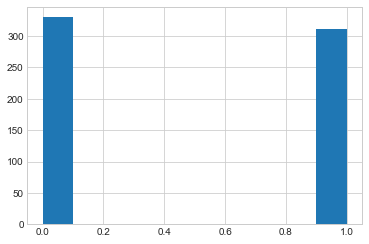

In [7]:
df_train['defaulter'].hist()

## Random Forest for feature selection

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

cols_to_use = fin_cols + macroEco_cols # exclude time series data

y = df_train[target]
X = df_train[cols_to_use]

model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10).fit(X,y)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

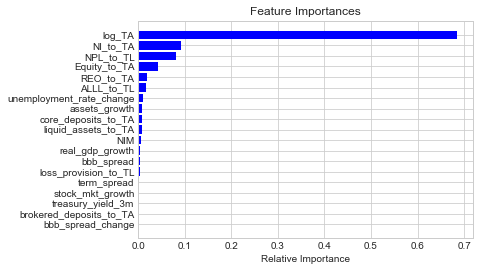

In [9]:
importances = model.feature_importances_
indices = np.argsort(importances)

features = X.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [10]:
# with the exception of unemployment rate, the most important features are financial 
# lets include only the first 6
my_features = fin_cols[:6]
my_features

['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 'ALLL_to_TL']

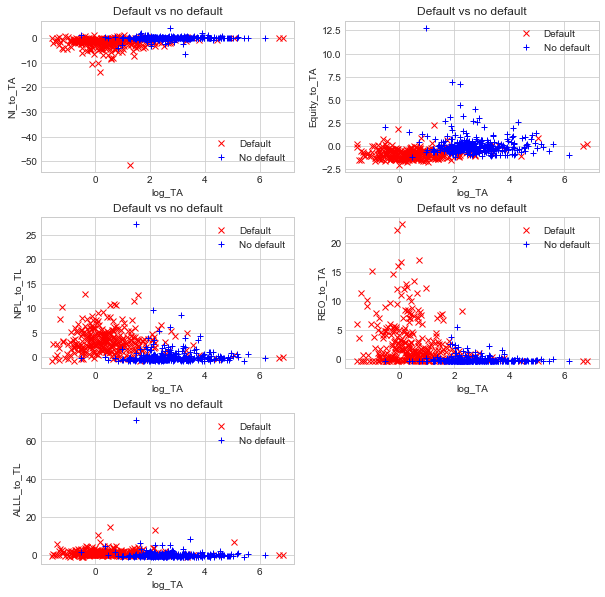

In [11]:
from toolbox import scatter_plot

# define vectors for plotting x and y
x_indx = [0, 0, 0, 0, 0] # vector for plotting axis x
y_indx = [1, 2, 3, 4, 5] # vector for plotting axis y

# call function
scatter_plot(df_train, my_features, target, x_indx, y_indx)

# Logistic Regression

Logistic regression uses probabilities to distinguish inputs and thereby puts them into separate output classes. We cannot use Linear Regression (LR) for classification problems because LR never deals with probabilistic values and, thus, there is no meaningful threshold at which you can distinguish one class from the other.

In logistic regression, we use the sigmoid activation, which maps the input values to output values that range from 0 to 1. The activation function is given by the equation:

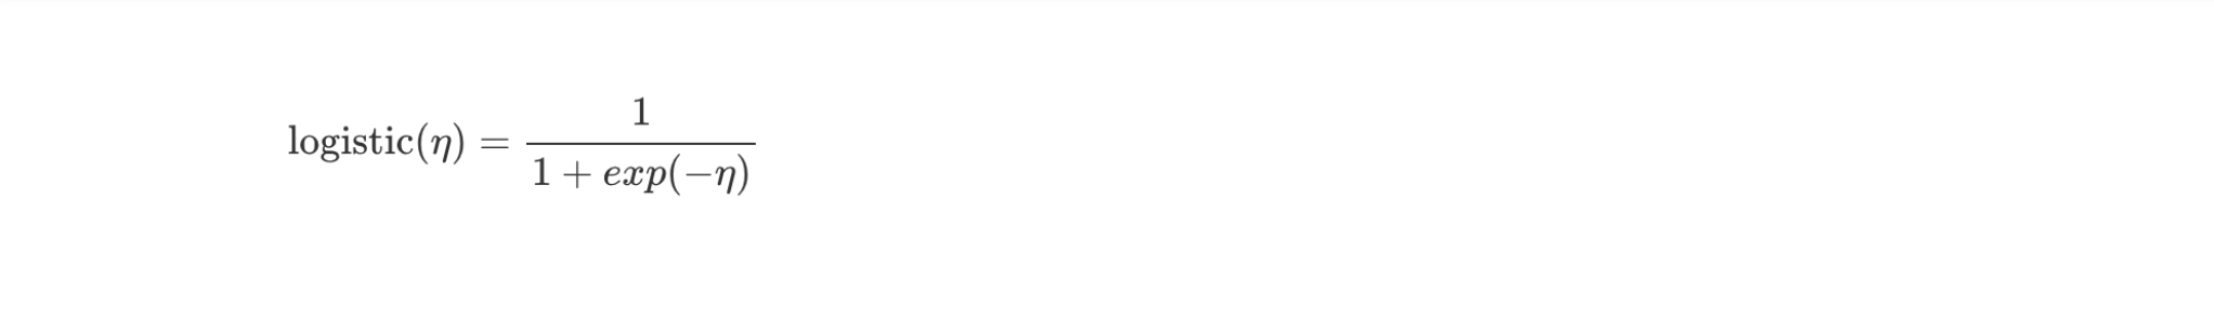

In linear regression, we use the mean squared error [MSE] which calculates the error between actual and predicted values. However, in logistic regression we cannot use MSE due to the nonlinearity induced by the logistic regression function. What we use is **cross-entropy** or **log loss function**.

## Sklearn

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Define target, X, y
target = 'defaulter'
y_train = df_train[target]
X_train = df_train[cols_to_use]
 
y_test = df_test[target]
X_test = df_test[cols_to_use]

# Apply logistic regression
lr_model = LogisticRegression(random_state=0, C=10, multi_class='ovr', solver='newton-cg').fit(X_train, y_train)
lr_model

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [13]:
# Get prediction
y_pred = lr_model.predict(X_test)

We get **5 False Negatives** (actual defaulters that are predicted as no defaulter) and **5 False Positives** (actual no defaulter that are predicted as defaulter). In this case, a false negative is more dangerous than a false positive. **Recall** looks at the number of false negatives that were thrown into the prediction mix. It is calculated by dividing True Positive by the sum of True Postives and False Negatives. Therefore, reducing recall would be an objective. 


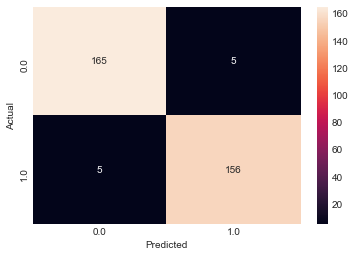

In [14]:
# confusion matrix
import seaborn as sns

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
#sns.heatmap(confusion_matrix, annot=True)
sns.heatmap(confusion_matrix, annot=True,annot_kws={"size": 10},fmt="d")
plt.show()

AUC score: 0.969766 


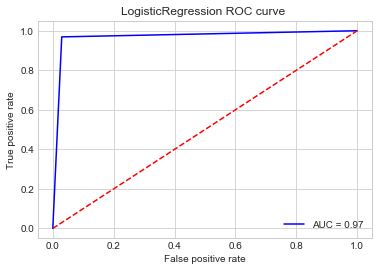

Accuracy: 0.9697885196374623


In [15]:
# ROC plot
from sklearn.metrics import accuracy_score
from toolbox import ROC_plot

ROC_plot(y_test, y_pred, lr_model)

print('Accuracy:', accuracy_score(y_test, y_pred))

A ROC curve is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate (precision) and False Positive Rate (recall). AUC measures the entire two-dimensional area underneath the entire ROC curve. Ideally, ROC curve has an AUC between 0.5 and 1.0, meaning it ranks a random positive example higher than a random negative example more than 50% of the time.  

## Keras

In [28]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [29]:
# Setup inputs and expected outputs 
cols = my_features

# inputs to Logistic Regression (via Tensorflow)
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add constant columns to both
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# exepectd outputs:
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

In [30]:
from tensorflow import keras

model = tf.keras.models.Sequential([ tf.keras.layers.Flatten(), tf.keras.layers.Dense(2, activation=tf.nn.softmax) ])

# compile
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train
model.fit(X_trainTf, y_trainTf, epochs=5)


Epoch 1/5
21/21 [==============================] - 0s 556us/step - loss: 1.3803 - accuracy: 0.2855
Epoch 2/5
21/21 [==============================] - 0s 581us/step - loss: 0.7592 - accuracy: 0.6427
Epoch 3/5
21/21 [==============================] - 0s 978us/step - loss: 0.5798 - accuracy: 0.7520
Epoch 4/5
21/21 [==============================] - 0s 814us/step - loss: 0.4930 - accuracy: 0.8206
Epoch 5/5
21/21 [==============================] - 0s 835us/step - loss: 0.4432 - accuracy: 0.8331


In [31]:
# Evaluate the model 
print("Evaluate on test data")
results = model.evaluate(X_testTf, y_testTf, batch_size=128)
print("Test loss: ", results[0])
print("Test acc: ", results[1])

Evaluate on test data
3/3 [==============================] - 0s 1ms/step - loss: 0.3711 - accuracy: 0.8429
Test loss:  0.3710877299308777
Test acc:  0.842900276184082


## Tensorflow

In [20]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [21]:
# Setup inputs and expected outputs 
cols = my_features

# inputs to Logistic Regression (via Tensorflow)
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add constant columns to both
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# outputs
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

y_trainTf.shape

(641, 1)

In [22]:
# Convert outputs into array of binary -> [0,1],[1,0],...
from keras.utils import to_categorical
y_train_binary = to_categorical(y_trainTf)
y_test_binary = to_categorical(y_testTf)

y_train_binary.shape

(641, 2)

In [23]:
# define hyperparameters
num_classes = len(np.unique(y_trainTf))
num_features = X_trainTf.shape[1]

input_layer = num_features # rename

learning_rate = 0.01
training_steps = 1000
batch_size = 256
display_step = 50

y_trainTf.shape

(641, 1)

In [24]:
# model training 
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(num_features,)) # number of features
dense_layer_1 = Dense(15, activation='relu')(input_layer)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(y_train_binary.shape[1], activation='softmax')(dense_layer_2)

# define model
model = Model(inputs=input_layer, outputs=output)

# definre optimizer (Adam) and learning rate
opt = keras.optimizers.Adam(learning_rate=learning_rate)

# compile the model, with loss categorical cross entropy and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

# Compile the model
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'], learning_rate=0.01)

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
history = model.fit(X_trainTf, y_train_binary, batch_size=50, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
11/11 [==============================] - 0s 11ms/step - loss: 0.4672 - acc: 0.8027 - val_loss: 0.2583 - val_acc: 0.9225
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 0.2173 - acc: 0.9277 - val_loss: 0.2265 - val_acc: 0.9302
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 0.1808 - acc: 0.9473 - val_loss: 0.2339 - val_acc: 0.9302
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 0.1718 - acc: 0.9512 - val_loss: 0.2380 - val_acc: 0.9225
Epoch 5/50
11/11 [==============================] - 0s 3ms/step - loss: 0.1609 - acc: 0.9512 - val_loss: 0.2231 - val_acc: 0.9225
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 0.1547 - acc: 0.9551 - val_loss: 0.2159 - val_acc: 0.9225
Epoch 7/50
11/11 [==============================] - 0s 3ms/step - loss: 0.1494 - acc: 0.9531 - val_loss: 0.2184 - val_acc: 0.9302
Epoch 8/50
11/11 [==============================] - 0s 2ms/step - loss: 0.1465 - acc: 0.9

In [26]:
score = model.evaluate(X_testTf, y_test_binary, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

11/11 [==============================] - 0s 684us/step - loss: 0.1528 - acc: 0.9607
Test Score: 0.15280930697917938
Test Accuracy: 0.9607250690460205
